In [14]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import matplotlib.pyplot as plt
from gasp import ssfp, responses, simulation, dataset

(128, 128, 16, 3)


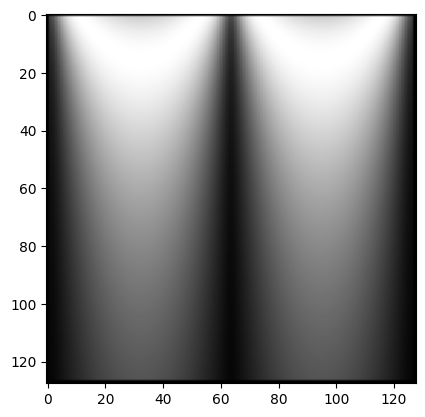

In [55]:
# Experiment parameters
width = 128
height = 128

alphaMin = 10
alphaMax = 90
npcs = 16
TRs = [5e-3, 10e-3, 20e-3]
nTRs = len(TRs)

T1, T2 = 1.2, .035
BetaMax = 2 * np.pi

# Simulate acquisition of phase-cycles for a single voxel
def simulate(T1, T2, TR, TE, pc, padding = 1):
    M = []
    beta = np.linspace(-BetaMax, BetaMax, 128-2*padding)
    f = beta / TRs[0] / (2 * np.pi)
    alphas = np.linspace(np.deg2rad(alphaMin), np.deg2rad(alphaMax), 128-2*padding).tolist()
    for alpha in alphas:
        M.append(ssfp.ssfp(T1, T2, TR, TE, alpha, pc, f0=f))
    M = np.stack(M)
    M = np.pad(M, (padding, padding))
    return M

pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
M = np.empty((height, width, npcs, nTRs), dtype=np.complex128)
for ii, TR in enumerate(TRs):
    TE = TR / 2.0
    for jj, pc in enumerate(pcs):
        M[..., jj, ii] = simulate(T1, T2, TR, TE, pc)
print(M.shape)

plt.imshow(abs(M[:,:,0,0]), cmap='gray')
plt.show()

In [56]:
M = np.reshape(M, M.shape[:-2] + (-1,))
print(M.shape)

X = M.reshape((-1, M.shape[-1]))
print(X.shape)

(128, 128, 48)
(16384, 48)


(16384,)
(48,)
(128, 128)


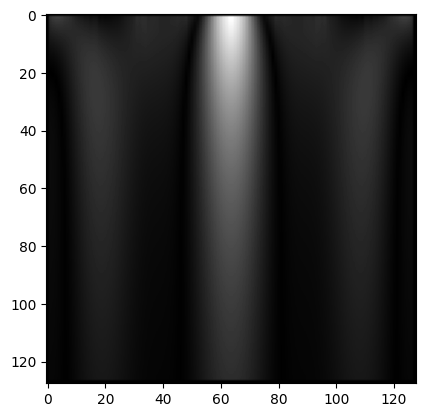

In [59]:
D = responses.gaussian(width, bw=0.2, shift=0)
D = np.tile(D, (int(X.shape[0]/D.size),))
print(D.shape)

# Now solve the system
A = np.linalg.lstsq(X, D, rcond=None)[0]
print(A.shape)

# y = A * x
y = X.dot(A).reshape(M.shape[0], M.shape[1])
print(y.shape)


plt.imshow(abs(y), cmap='gray')
plt.show()